In [ ]:
import os
import sys

from time import sleep
from os import getcwd
from random import randint

import cv2
import numpy as np

from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.utils import shuffle

In [373]:
# Dataset extraction (from photo) routines
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in xrange(200, image.shape[0], stepSize):
        for x in xrange(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            
def sharpen(image):
    #Create the identity filter, but with the 1 shifted to the right!
    kernel = np.zeros( (9,9), np.float32)
    kernel[4,4] = 2.0   #Identity, times two! 
    #Create a box filter:
    boxFilter = np.ones( (9,9), np.float32) / 81.0
    #Subtract the two:
    kernel = kernel - boxFilter
    #Note that we are subject to overflow and underflow here...but I believe that
    # filter2D clips top and bottom ranges on the output, plus you'd need a
    # very bright or very dark pixel surrounded by the opposite type.
    return cv2.filter2D(image, -1, kernel)

In [3]:
# Split image into 60px x 60px frames and save to files with sequence numbering (i.e. extract samples)
filename = '026.png'
path = '/home/chip/Dropbox/LITS/ML-003/dataset/processed_dataset/prespective_correction/'
img_path = os.path.join(path, filename)

img = cv2.imread(img_path, 1)
img_height, img_width = img.shape[:2]
STEP = 60 # px

windows_gen = sliding_window(img, stepSize = STEP - 30, windowSize=(STEP, STEP))
x, y, window = windows_gen.next()
counter = 0

if not os.path.exists(path):
    while True:    
        cv2.imshow('preview', window)
        cv2.imwrite(os.path.join(path, 'features_{0}/{1}.png'.format(filename, counter)), window)
        counter += 1
        _, _, window = windows_gen.next()    
        key_pressed = 0xFF & cv2.waitKey(1)
        if key_pressed == ord('q'):
            break
        elif key_pressed == ord('n'):
            pass
    cv2.destroyAllWindows()

In [ ]:
# Loading routines
def load_dataset(path, downsample=False, ret_size=False):
    """Loads samples into feature vectors from files (e.g '001.png').
    Args:
        path -- path to the dir with files
        downsample -- downsamples img if True
        ret_size -- returns (rows, cols) tuple if True
    Returns:
        img.shape[:2] -- shape (rows, cols) of original image matrix
        images -- list of feature vectors
    """
    images_init = True
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)
        
        if downsample:
            # Downsample image (by 50%)
            img = cv2.pyrDown(img)
        if images_init:
            # Initialize images np.array
            images_init = not images_init
            # Flatten rows x cols matrix to vector of rows ('-1' - set length automaticaly)
            # Create np.array of row vectors
            images = np.array([np.reshape(img, -1)])
        else:
            # Add new row to the end of images array
            images = np.vstack((images, np.reshape(img, -1)))
    if ret_size:
        return img.shape[:2], images
    return images

def preview_examples(rows=30, cols=30):
    plt.figure(1)
    pos_idx = randint(1, len(pos_data))
    plt.title('POSITIVE (ex. #{})'.format(pos_idx))
    plt.imshow(pos_data[pos_idx].reshape((rows, cols)))

    plt.figure(2)
    neg_idx = randint(1, len(neg_data))
    plt.title('NEGATIVE (ex.#{})'.format(neg_idx))
    plt.imshow(neg_data[neg_idx].reshape((rows, cols)))
    plt.show()

In [324]:
# Load dataset from files
pos_path = './dataset/positive/'
neg_path = './dataset/negative/'
(rows, cols), pos_data = load_dataset(path=pos_path, downsample=True, ret_size=True)
neg_data = load_dataset(path=neg_path, downsample=True)

True
True


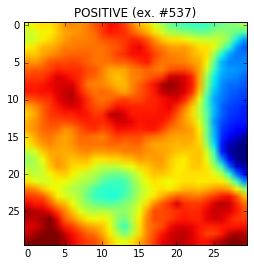

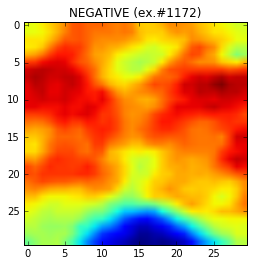

In [368]:
preview_examples(rows, cols)

In [ ]:
# Cleaup negative samples from "like positive" ones
# !!!

In [604]:
# Prepare dataset (X, y) & shuffle dataset
num_features = pos_data.shape[1]
num_pos_samples = pos_data.shape[0]
num_neg_samples = 2000 #neg_data.shape[0] 
num_samples = num_pos_samples + num_neg_samples

X = np.vstack((pos_data, neg_data[:num_neg_samples])).astype(np.float64)
y = np.zeros([num_samples], dtype=np.float64)
y[0:pos_data.shape[0]] = 1
# Shuffle
X, y = shuffle(X, y, random_state=0)

In [605]:
np.unique(y)

array([ 0.,  1.])

In [606]:
# Spilt data to training, validation and test sets (60%, 20%, 20%)
idx_train = int(num_samples * 0.6)
idx_cv = idx_train + int(num_samples * 0.2)
X_train = X[:idx_train]
y_train = y[:idx_train]
X_cv = X[idx_train:idx_cv]
y_cv = y[idx_train:idx_cv]
X_test = X[idx_cv:]
y_test = y[idx_cv:]

In [607]:
# Set SVM
clf = svm.SVC(C=0.85, kernel='linear')

#SVC(C=0.2, cache_size=200, class_weight=None, coef0=0.0,
#  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
#  max_iter=-1, probability=False, random_state=None, shrinking=True,
#  tol=0.001, verbose=False)

In [608]:
# Train SVC
dataset_sizes = [100, 200, 500, 1000, y_train.shape[0]]
dataset_idx = len(dataset_sizes)
train_scores = []
cv_scores = []
for n in dataset_sizes[:dataset_idx]:
    clf.fit(X_train[:n], y_train[:n])
    train_scores.append(clf.score(X_train, y_train))
    cv_scores.append(clf.score(X_cv, y_cv))
    print('Training set size: {}\nAccuracy: {:0.3f}'.format(n, cv_scores[dataset_sizes.index(n)]))

Training set size: 100
Accuracy: 0.771
Training set size: 200
Accuracy: 0.771
Training set size: 500
Accuracy: 0.775
Training set size: 1000
Accuracy: 0.777
Training set size: 1653
Accuracy: 0.789


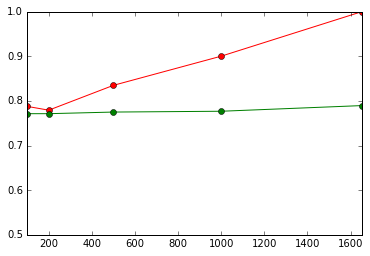

In [609]:
plt.plot(dataset_sizes[:dataset_idx], train_scores, '-ro', dataset_sizes[:dataset_idx], cv_scores, '-go')
plt.axis([100, y_train.shape[0], 0.5, 1])

plt.show()

In [591]:
# Test SVM
#prediction = clf.predict(X_cv)
clf.score(X_cv, y_cv)

0.77840909090909094

In [602]:
# Use classifier on new photos to detect brood location
#!!!

78